# Solve cartpole with vanilla pg

Solve [Cartpole](https://gym.openai.com/envs/CartPole-v0/) with the vanilla policy gradient method, REINFORCE.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we use a network with softmax output.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity 

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return the sequence of actions, states and rewards. This allows us to replace the integral by a Monte Carlo average

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.python.ops.nn import relu, softmax
import gym

In [2]:
env = gym.make('CartPole-v0')

[2017-12-20 13:56:41,941] Making new env: CartPole-v0


In [3]:
class Policy(object):
    """Policy network"""
    
    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        # placeholders
        self.states = tf.placeholder(tf.float32, [None, n_inputs], name='states')
        self.actions = tf.placeholder(tf.int32, [None, 2], name='actions')
        self.returns = tf.placeholder(tf.float32, [None], name='returns')
        # network
        net = tf.layers.dense(inputs=self.states, units=n_hidden, activation=relu, name='hidden')
        self.out = tf.layers.dense(inputs=net, units=n_outputs, activation=softmax, name='out')
        # training
        action_probabilities = tf.gather_nd(self.out, self.actions)
        self.loss = -tf.reduce_mean(tf.multiply(tf.log(action_probabilities), self.returns))
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        self.update = optimizer.minimize(self.loss)

In [4]:
def get_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

In [5]:
# training settings

num_episodes = 2000
rollout_limit = env.spec.timestep_limit # max rollout length
discount_factor = .99 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now

print_freq = 100

# setup policy network

n_inputs = env.observation_space.shape[0]
n_hidden = 20
n_outputs = env.action_space.n

tf.reset_default_graph()
policy = Policy(n_inputs, n_hidden, n_outputs, learning_rate)

saver = tf.train.Saver()
save_path = 'tmp/cartpole_vanilla_pg'

# train policy network

try:
    training_rewards, losses = [], []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('start training')
        for i in range(num_episodes):
            rollout = []
            s = env.reset()
            for j in range(rollout_limit):
                # generate rollout by iteratively evaluating the current policy on the environment
                a_prob = sess.run(fetches=policy.out, feed_dict={policy.states: [s]})
                a = (np.cumsum(np.asarray(a_prob)) > np.random.rand()).argmax() # sample action
                s1, r, done, _ = env.step(a)
                rollout.append([s, a, r])
                s = s1
                if done: break
            rollout = np.array(rollout)
            states = list(rollout[:,0])
            actions = np.column_stack((range(j+1), list(rollout[:,1])))
            rewards = list(rollout[:,2])
            returns = get_returns(rewards, discount_factor)
            # policy gradient update
            feed_dict = {policy.states: states, policy.actions: actions, policy.returns: returns}
            loss, _ = sess.run(fetches=[policy.loss, policy.update], feed_dict=feed_dict)
            # bookkeeping
            training_rewards.append(sum(rewards))
            losses.append(loss)
            # print
            if (i+1) % print_freq == 0:
                # validation
                validation_rewards = []
                for _ in range(10):
                    s = env.reset()
                    reward = 0
                    for _ in range(rollout_limit):
                        a = sess.run(fetches=policy.out, feed_dict={policy.states: [s]}).argmax()
                        s, r, done, _ = env.step(a)
                        reward += r
                        if done: break
                    validation_rewards.append(reward)
                print('%4d. mean training reward: %6.2f, mean validation reward: %6.2f, mean loss: %7.4f' % (i+1, np.mean(training_rewards[-print_freq:]), np.mean(validation_rewards), np.mean(losses[-print_freq:])))
        print('done')
        # save model
        if not os.path.exists(save_path): os.makedirs(save_path)
        latest = saver.save(sess, os.path.join(save_path, 'model'))
except KeyboardInterrupt:
    pass    

start training
 100. mean training reward:  28.15, mean validation reward:  55.00, mean loss:  8.8922
 200. mean training reward:  34.68, mean validation reward:  65.90, mean loss: 10.3338
 300. mean training reward:  43.37, mean validation reward: 170.70, mean loss: 12.2001
 400. mean training reward:  52.41, mean validation reward: 177.70, mean loss: 13.8647
 500. mean training reward:  58.99, mean validation reward: 178.20, mean loss: 15.2078
 600. mean training reward:  60.50, mean validation reward: 171.80, mean loss: 15.3151
 700. mean training reward:  82.30, mean validation reward: 200.00, mean loss: 18.9679
 800. mean training reward:  98.98, mean validation reward: 197.80, mean loss: 21.6467
 900. mean training reward: 118.63, mean validation reward: 197.90, mean loss: 24.2112
1000. mean training reward: 141.14, mean validation reward: 200.00, mean loss: 27.1601
1100. mean training reward: 156.68, mean validation reward: 200.00, mean loss: 29.3861
1200. mean training reward: 

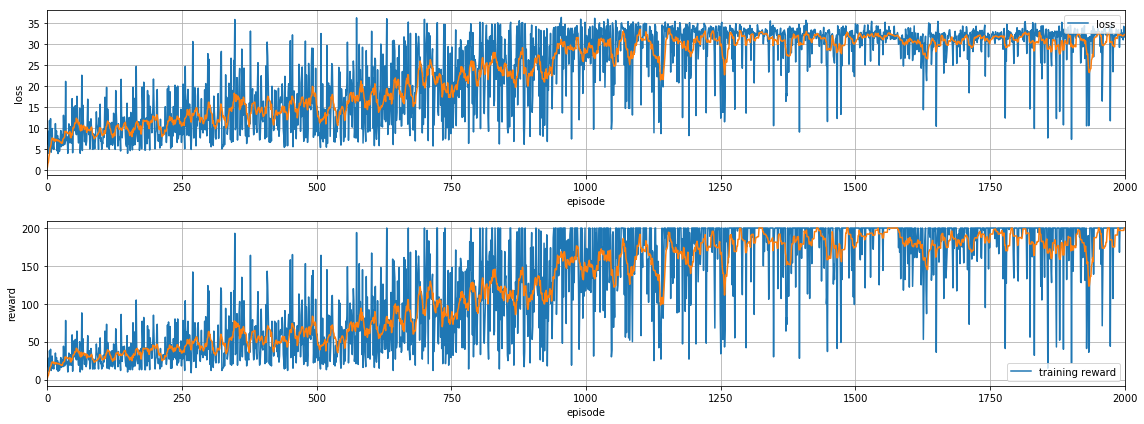

In [6]:
# plot results

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=1); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

In [7]:
# review solution
with tf.Session() as sess:
    saver.restore(sess, latest)
    s = env.reset()
    for _ in range(env.spec.timestep_limit):
        env.render()
        a = sess.run(policy.out, feed_dict={policy.states: [s]}).argmax()
        s, r, done, _ = env.step(a)
    env.render(close=True)

INFO:tensorflow:Restoring parameters from tmp/cartpole_vanilla_pg1/model


[2017-12-20 13:58:31,192] Restoring parameters from tmp/cartpole_vanilla_pg1/model
